In [1]:

!pip -q install -U datasets transformers sentencepiece seaborn

import os, random, numpy as np, pandas as pd, torch
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, TextClassificationPipeline
)
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt, seaborn as sns

# Reproducibility
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 12.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 102.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 38.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 88.2 MB/s eta 0:00:00:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
pylibcudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; plat

2025-10-29 15:53:19.724132: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761753199.965601      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761753200.036722      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Using device: cuda


In [2]:
# ===============================
# ✅ Urdu Dataset Preprocessing (umar178/UrduMultiDomainClassification)
# ===============================
from datasets import load_dataset
import pandas as pd, os

# Load dataset
ds_ur = load_dataset("umar178/UrduMultiDomainClassification")

# Convert to DataFrame
df_ur = pd.DataFrame(ds_ur["train"])
print("Columns:", df_ur.columns.tolist())
print("Unique sentiments:", df_ur["sentiment"].unique())

# Keep only Positive & Negative (drop Neutral)
df_ur = df_ur[df_ur["sentiment"].isin(["positive", "negative"])].reset_index(drop=True)

# Map to binary: positive → 1, negative → 0
df_ur["label"] = df_ur["sentiment"].map({"positive": 1, "negative": 0})

# Keep only text and label columns
df_ur = df_ur[["text", "label"]]

print("✅ Urdu dataset ready →", df_ur.shape)
print(df_ur.head())

# Save for later reuse
os.makedirs("/kaggle/working/datasets", exist_ok=True)
df_ur.to_csv("/kaggle/working/datasets/urdu.csv", index=False)
print("💾 Saved Urdu dataset → /kaggle/working/datasets/urdu.csv")


README.md: 0.00B [00:00, ?B/s]

Dataset%20-%20Sheet1.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/34819 [00:00<?, ? examples/s]

Columns: ['text', 'sentiment', 'topic', 'intent', 'binary']
Unique sentiments: ['positive' 'negative' 'neutral' 'request']
✅ Urdu dataset ready → (20933, 2)
                                 text  label
0             آج موسم بہت خوشگوار ہے۔      1
1               یہ کتاب بہت دلچسپ ہے۔      1
2         میں اپنا فون کھو بیٹھا ہوں۔      0
3            یہ گاڑی بہت تیز چلتی ہے۔      1
4  میں نے کل رات ایک اچھا خواب دیکھا۔      1
💾 Saved Urdu dataset → /kaggle/working/datasets/urdu.csv


In [3]:
# ===============================
# ✅ Hindi Sentiment Dataset (fixed for jishnavi/hindi-language-dataset)
# ===============================
from datasets import load_dataset
import pandas as pd, os

# 🔹 1️⃣ Load dataset
ds_hi = load_dataset("jishnavi/hindi-language-dataset")

# 🔹 2️⃣ Convert to DataFrame
df_hi = pd.DataFrame(ds_hi["train"])
print("Columns:", df_hi.columns.tolist())
print("Unique sentiments:", df_hi["Sentiment"].unique())

# 🔹 3️⃣ Keep only Positive / Negative
df_hi = df_hi[df_hi["Sentiment"].isin(["Positive", "Negative"])].reset_index(drop=True)

# 🔹 4️⃣ Map to binary: Positive → 1, Negative → 0
df_hi["label"] = df_hi["Sentiment"].map({"Positive": 1, "Negative": 0})

# 🔹 5️⃣ Keep only Hindi sentence and label
df_hi = df_hi.rename(columns={"Hindi_Sentence": "text"})[["text", "label"]]

print("✅ Hindi dataset ready:", df_hi.shape)
print(df_hi.head())

# 🔹 6️⃣ Save for reuse
os.makedirs("/kaggle/working/datasets", exist_ok=True)
df_hi.to_csv("/kaggle/working/datasets/hindi.csv", index=False)
print("💾 Saved Hindi dataset → /kaggle/working/datasets/hindi.csv")


README.md:   0%|          | 0.00/967 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


hindi_large_dataset.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Columns: ['Hindi_Sentence', 'English_Translation', 'Sentiment', 'Topic']
Unique sentiments: ['Neutral' 'Positive' 'Negative']
✅ Hindi dataset ready: (810, 2)
                                      text  label
0                  आज मौसम बहुत सुहाना है।      1
1  नई तकनीक हमारे जीवन को आसान बना रही है।      1
2          आज शेयर बाजार में गिरावट आई है।      0
3          आज शेयर बाजार में गिरावट आई है।      0
4                 यह फिल्म बहुत शानदार थी!      1
💾 Saved Hindi dataset → /kaggle/working/datasets/hindi.csv


In [4]:
# ===============================
# ✅ Load Bangla Data from Text Files
# ===============================
import pandas as pd, os

pos_path = "/kaggle/input/bangladata/all_positive_8500.txt"
neg_path = "/kaggle/input/bangladata/all_negative_3307.txt"

# Read files (one sentence per line)
with open(pos_path, encoding="utf-8") as f:
    pos_texts = [line.strip() for line in f if line.strip()]
with open(neg_path, encoding="utf-8") as f:
    neg_texts = [line.strip() for line in f if line.strip()]

# Create DataFrame
df_pos = pd.DataFrame({"text": pos_texts, "label": 1})
df_neg = pd.DataFrame({"text": neg_texts, "label": 0})
df_bn = pd.concat([df_pos, df_neg], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

print("✅ Bangla dataset loaded:")
print(df_bn.head())
print(f"Total samples: {len(df_bn)} (pos={len(df_pos)}, neg={len(df_neg)})")

# Save for re-use
os.makedirs("/kaggle/working/datasets", exist_ok=True)
df_bn.to_csv("/kaggle/working/datasets/bangla.csv", index=False)
print("💾 Saved Bangla dataset → /kaggle/working/datasets/bangla.csv")


✅ Bangla dataset loaded:
                                                text  label
0  আমার বাংলাদেশের নাটকের ভুতে ধরেছে, ওঝা কোথায় প...      1
1  ভাই, আপনার হার্ড ফ্যান আমি!বাট এইযে এই নাটকে য...      0
2  অনেক ভালো একটা নাটক ।।অনেক ভালোবাসি ভাই তুমাকে...      1
3                           বালের নাটক বালের কনসেপ্ট      0
4             দারুন হয়েছে, এই রকম নাটক আরো দেখতে চাই      1
Total samples: 11807 (pos=8500, neg=3307)
💾 Saved Bangla dataset → /kaggle/working/datasets/bangla.csv


In [5]:
# ===============================
# ✅ English SST-2 Sentiment Dataset
# ===============================
from datasets import load_dataset
import pandas as pd, os

# 1️⃣ Load SST-2 from Hugging Face
ds_en = load_dataset("stanfordnlp/sst2")

# 2️⃣ Inspect structure
print(ds_en)
print("Sample example:", ds_en["train"][0])

# 3️⃣ Convert to DataFrame
df_en = pd.DataFrame(ds_en["train"])
print("Columns:", df_en.columns.tolist())
print("Unique labels:", df_en["label"].unique())

# 4️⃣ Map label to binary (already 0 = negative, 1 = positive)
df_en = df_en.rename(columns={"sentence": "text"})[["text", "label"]]
df_en = df_en[df_en["label"].isin([0, 1])].reset_index(drop=True)

print("✅ English dataset ready:", df_en.shape)
print(df_en.head())

# 5️⃣ Save cleaned dataset for reuse
os.makedirs("/kaggle/working/datasets", exist_ok=True)
df_en.to_csv("/kaggle/working/datasets/english.csv", index=False)
print("💾 Saved English dataset → /kaggle/working/datasets/english.csv")


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})
Sample example: {'idx': 0, 'sentence': 'hide new secretions from the parental units ', 'label': 0}
Columns: ['idx', 'sentence', 'label']
Unique labels: [0 1]
✅ English dataset ready: (67349, 2)
                                                text  label
0       hide new secretions from the parental units       0
1               contains no wit , only labored gags       0
2  that loves its characters and communicates som...      1
3  remains utterly satisfied to remain the same t...      0
4  on the worst revenge-of-the-nerds clichés the ...      0
💾 Saved English dataset → /kaggle/working/datasets/english.csv


In [6]:
# ===============================
# ✅ Cell 2 — Load All Datasets (English + Hindi + Urdu + Bangla)
# ===============================
import pandas as pd, os

DATA_DIR = "/kaggle/working/datasets"

# 1️⃣ Verify files exist
required_files = ["english.csv", "hindi.csv", "urdu.csv", "bangla.csv"]
for f in required_files:
    path = os.path.join(DATA_DIR, f)
    assert os.path.exists(path), f"⚠️ Missing file: {path} — run its preparation cell first!"
print("✅ All dataset files found.")

# 2️⃣ Load datasets
df_en = pd.read_csv(f"{DATA_DIR}/english.csv")
df_hi = pd.read_csv(f"{DATA_DIR}/hindi.csv")
df_ur = pd.read_csv(f"{DATA_DIR}/urdu.csv")
df_bn = pd.read_csv(f"{DATA_DIR}/bangla.csv")

# 3️⃣ Basic sanity checks
for name, df in zip(["English", "Hindi", "Urdu", "Bangla"], [df_en, df_hi, df_ur, df_bn]):
    print(f"\n{name} — samples: {len(df)} | columns: {list(df.columns)} | unique labels: {df['label'].unique()[:5]}")
    print(df.head(2))

# 4️⃣ Ensure consistent column names & types
for df in [df_en, df_hi, df_ur, df_bn]:
    df["text"] = df["text"].astype(str)
    df["label"] = df["label"].astype(int)

# 5️⃣ Save verified copies (optional)
for name, df in zip(["english","hindi","urdu","bangla"], [df_en, df_hi, df_ur, df_bn]):
    path = f"{DATA_DIR}/{name}_verified.csv"
    df.to_csv(path, index=False)
    print(f"💾 Verified {name} dataset saved → {path}")

print("\n✅ All datasets loaded, verified, and ready for tokenization!")


✅ All dataset files found.

English — samples: 67349 | columns: ['text', 'label'] | unique labels: [0 1]
                                           text  label
0  hide new secretions from the parental units       0
1          contains no wit , only labored gags       0

Hindi — samples: 810 | columns: ['text', 'label'] | unique labels: [1 0]
                                      text  label
0                  आज मौसम बहुत सुहाना है।      1
1  नई तकनीक हमारे जीवन को आसान बना रही है।      1

Urdu — samples: 20933 | columns: ['text', 'label'] | unique labels: [1 0]
                      text  label
0  آج موسم بہت خوشگوار ہے۔      1
1    یہ کتاب بہت دلچسپ ہے۔      1

Bangla — samples: 11807 | columns: ['text', 'label'] | unique labels: [1 0]
                                                text  label
0  আমার বাংলাদেশের নাটকের ভুতে ধরেছে, ওঝা কোথায় প...      1
1  ভাই, আপনার হার্ড ফ্যান আমি!বাট এইযে এই নাটকে য...      0
💾 Verified english dataset saved → /kaggle/working/datasets/english_veri

In [7]:
from datasets import Dataset
from transformers import AutoTokenizer

model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_batch(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

# Convert all DataFrames to HuggingFace Datasets
ds_en = Dataset.from_pandas(df_en).map(tokenize_batch, batched=True)
ds_hi = Dataset.from_pandas(df_hi).map(tokenize_batch, batched=True)
ds_ur = Dataset.from_pandas(df_ur).map(tokenize_batch, batched=True)
ds_bn = Dataset.from_pandas(df_bn).map(tokenize_batch, batched=True)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/810 [00:00<?, ? examples/s]

Map:   0%|          | 0/20933 [00:00<?, ? examples/s]

Map:   0%|          | 0/11807 [00:00<?, ? examples/s]

In [8]:
# ===============================
# ✅ Build Balanced Multilingual Datasets (EN + HI + UR)
# ===============================
from datasets import interleave_datasets

# Create a config-like dictionary for reproducibility
CFG = {"seed": 42}

# Each dataset (ds_en, ds_hi, ds_ur) should already be tokenized (Cell 3)
# We’ll split them into train/validation parts before interleaving
split_ratio = 0.1  # 10% validation

tok_sources = {}
for tag, ds in zip(["EN", "HI", "UR"], [ds_en, ds_hi, ds_ur]):
    split = ds.train_test_split(test_size=split_ratio, seed=CFG["seed"])
    tok_sources[tag] = split
    print(f"{tag}: train={len(split['train'])}, val={len(split['test'])}")

# Combine datasets using balanced interleaving
train_parts = [tok_sources[tag]["train"] for tag in ["EN", "HI", "UR"]]
eval_parts = [tok_sources[tag]["test"] for tag in ["EN", "HI", "UR"]]

train_balanced = interleave_datasets(
    train_parts,
    probabilities=[1.0 / len(train_parts)] * len(train_parts),
    seed=CFG["seed"],
    stopping_strategy="all_exhausted"  # ensures all datasets are fully used
)
valid_balanced = interleave_datasets(
    eval_parts,
    probabilities=[1.0 / len(eval_parts)] * len(eval_parts),
    seed=CFG["seed"],
    stopping_strategy="all_exhausted"
)

print(f"\n✅ train_balanced: {len(train_balanced)} samples")
print(f"✅ valid_balanced: {len(valid_balanced)} samples")


EN: train=60614, val=6735
HI: train=729, val=81
UR: train=18839, val=2094

✅ train_balanced: 181983 samples
✅ valid_balanced: 20049 samples


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded model: xlm-roberta-base

🚀 Starting multilingual balanced fine-tuning...



/tmp/ipykernel_37/4037516682.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.106100,0.105064,0.968128,0.969066
2,0.070600,0.114508,0.972268,0.973143
3,0.055100,0.124297,0.971171,0.971942
4,0.038900,0.137913,0.971669,0.972563


Device set to use cuda:0



✅ Validation results:
{'eval_loss': 0.11450832337141037, 'eval_accuracy': 0.9722679435383311, 'eval_f1': 0.9731426915273886, 'eval_runtime': 133.5717, 'eval_samples_per_second': 150.099, 'eval_steps_per_second': 4.694, 'epoch': 4.0}

🔍 Running Bangla test evaluation safely...

📊 Final Evaluation on Bangla Test:
              precision    recall  f1-score   support

           0     0.7424    0.8089    0.7742      3307
           1     0.9230    0.8908    0.9066      8500

    accuracy                         0.8679     11807
   macro avg     0.8327    0.8499    0.8404     11807
weighted avg     0.8724    0.8679    0.8695     11807



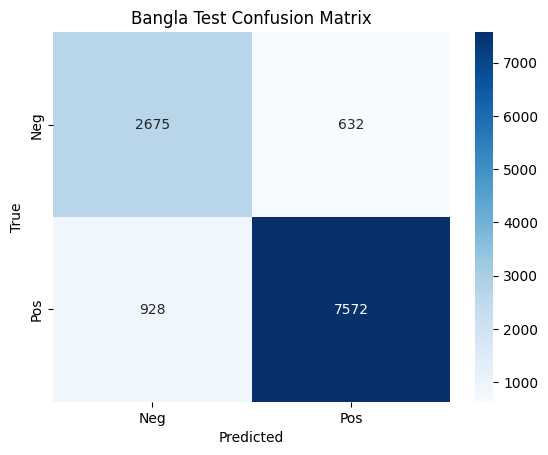

💾 Final model saved → /kaggle/working/final_balanced_multilingual_en_hi_ur_to_bn


In [10]:
# ===============================
# ✅ Multilingual Balanced Fine-Tuning + Bangla Evaluation
# ===============================
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, TextClassificationPipeline
)
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, warnings, torch

warnings.filterwarnings("ignore", category=UserWarning)

# 1️⃣ Initialize model
model_name = "xlm-roberta-base"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
print("✅ Loaded model:", model_name)

# 2️⃣ Define metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

# 3️⃣ Training arguments
args = TrainingArguments(
    output_dir="/kaggle/working/multilingual_balanced",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="/kaggle/working/logs",
    report_to="none",   # disables WandB/TensorBoard logging
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True
)

# 4️⃣ Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_balanced,
    eval_dataset=valid_balanced,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# 5️⃣ Train
torch.cuda.empty_cache()
print("\n🚀 Starting multilingual balanced fine-tuning...\n")
trainer.train()

# 6️⃣ Evaluate on validation data
eval_results = trainer.evaluate()
print("\n✅ Validation results:")
print(eval_results)

# 7️⃣ Evaluate on Bangla test set
# 7️⃣ Evaluate on Bangla test set (safe, batched, truncated)
from tqdm import tqdm

pipe = TextClassificationPipeline(
    model=trainer.model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1,
    truncation=True,          # ✅ ensure sequences are cut at 512 tokens
    max_length=512,           # ✅ hard safety cap
    batch_size=32,            # ✅ efficient batching
)

y_true, y_pred = [], []
texts = [ex["text"] for ex in ds_bn]
labels = [int(ex["label"]) for ex in ds_bn]

print("\n🔍 Running Bangla test evaluation safely...")
preds = pipe(texts, truncation=True, max_length=512, batch_size=32)

for pred, true in zip(preds, labels):
    label = pred["label"]
    y_pred.append(1 if label.endswith("_1") else 0)
    y_true.append(true)

print("\n📊 Final Evaluation on Bangla Test:")
print(classification_report(y_true, y_pred, digits=4))

# 8️⃣ Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Neg","Pos"], yticklabels=["Neg","Pos"])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Bangla Test Confusion Matrix")
plt.show()

# 9️⃣ Save model
out_dir = "/kaggle/working/final_balanced_multilingual_en_hi_ur_to_bn"
trainer.model.save_pretrained(out_dir)
tokenizer.save_pretrained(out_dir)
print("💾 Final model saved →", out_dir)
